In [1]:
import numpy as np
import math
from fractions import Fraction
import itertools
from biotuner_utils import *
from biotuner_offline import *
import matplotlib.pyplot as plt
from numpy import array, zeros, ones, arange, log2, sqrt, diff, concatenate
import emd
from PyEMD import EMD, EEMD
from scipy.signal import butter, lfilter
import colorednoise as cn
from biotuner import *
import mne

## Load dataset

In [2]:

#path = 'D:/Science/EEG_data/'
path = 'C:/Users/Dell/GitHub/CoCoBrainChannel/'
epochs = mne.read_epochs(path+'pareidolia_run2.fif')
#epochs = mne.read_epochs('C:/Users/Antoine/github/Data_EEG/pareidolia_run1.fif')
epochs = epochs.apply_baseline((-1.5, -0.1))
#epochs = epochs.crop(0.5, 7.5)
epochs_data = epochs.get_data()

Reading C:/Users/Dell/GitHub/CoCoBrainChannel/pareidolia_run2.fif ...


<ipython-input-2-450bd368b88c>:3: RuntimeWarning: This filename (C:/Users/Dell/GitHub/CoCoBrainChannel/pareidolia_run2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path+'pareidolia_run2.fif')


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available


C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py

104 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


## Initialize biotuner object and methods

In [9]:
class biotuner(object):
    
    '''Class used to derive peaks information, musical scales and related metrics from time series  
    
    Example of use:       
    biotuning = biotuner(sf = 1000)
    biotuning.peaks_extraction(data)
    biotuning.peaks_extension()
    biotuning.peaks_metrics()
    '''
    
    def __init__(self, sf, peaks_function = 'EEMD', precision = 0.1, compute_sub_ratios = False, 
                 n_harm = 10, harm_function = 'mult', extension_method = 'consonant_harmonic_fit',
                 ratios_n_harms = 5, ratios_harms = False, ratios_inc = False, ratios_inc_fit = False):
        '''
        sf: int
            sampling frequency (in Hz)
            
        ///// PEAKS EXTRACTION ARGUMENTS ///// 
        peaks_function: str
            Defaults to 'EEMD'.
            Defines the method to use for peak extraction
            Peaks values are defined as the frequency value of the FFT bin with maximum amplitude 
            'fixed' : ranges of frequency bands are fixed
            'adapt' : ranges of frequency bands are defined based on the alpha peak
            'EMD': Intrinsic Mode Functions (IMFs) are derived from Empirical Mode Decomposition (EMD)  
                   FFT is computed on each IMF
            'EEMD': Intrinsic Mode Functions (IMFs) are derived from Ensemble Empirical Mode Decomposition (EMD)  
                    FFT is computed on each IMF
            'HH1D_max': maximum values of the 1d Hilbert-Huang transform on each IMF using EEMD.
            'harmonic_peaks': keeps peaks for which n other peaks are harmonics
        precision: float
            Defaults to 0.1
            precision of the peaks (in Hz)
            When HH1D_max is used, bins are in log scale.
        compute_sub_ratios: str
            Default to False
            When set to True, include ratios < 1 in peaks_ratios attribute
            
        ///// EXTENDED PEAKS ARGUMENTS /////
        n_harm: int
            Defaults to 10.
            Set the number of harmonics to compute in harmonic_fit function
        harm_function: str
            Defaults to 'mult'
            Computes harmonics from iterative multiplication (x, 2x, 3x, ...nx) or division (x, x/2, x/3, ...x/n)
            Set to 'mult' or 'div'  
        extension_method: str
            ['harmonic_fit', 'consonant', 'multi_consonant', 'consonant_harmonic_fit', 'multi_consonant_harmonic_fit']
            
        ///// RATIOS EXTENSION ARGUMENTS /////
        ratios_n_harms: int
            Defaults to 5.
            Defines to number of harmonics or exponents for extended ratios
        ratios_harms: boolean
            Defaults to False.
            When set to True, harmonics (x*1, x*2, x*3...,x*n) of specified ratios will be computed.
        ratios_inc: boolean
            Defaults to False.
            When set to True, exponentials (x**1, x**2, x**3,...x**n) of specified ratios will be computed.
        ratios_inc_fit: boolean
            Defaults to False.
            When set to True, a fit between exponentials (x**1, x**2, x**3,...x**n) of specified ratios will be computed.
        
        '''
        self.sf = sf
        '''Initializing arguments for peak extraction'''
        self.peaks_function = peaks_function
        self.precision = precision
        self.compute_sub_ratios = compute_sub_ratios
        '''Initializing arguments for peaks metrics'''
        self.n_harm = n_harm
        self.harm_function = harm_function
        self.extension_method = extension_method
        '''Initializing dictionary for scales metrics'''
        self.scale_metrics = {}
        '''Initializing arguments for ratios extension'''
        self.ratios_n_harms = ratios_n_harms
        self.ratios_harms = ratios_harms
        self.ratios_inc = ratios_inc
        self.ratios_inc_fit = ratios_inc_fit
        
    
    
    '''First method to use. Requires data as input argument
       Generates self.peaks and self.peaks_ratios attributes'''

    def peaks_extraction (self, data, peaks_function = None, FREQ_BANDS = None, precision = None, sf = None, min_freq = 1, max_freq = 80, min_harms = 2, 
                          compute_sub_ratios = None, ratios_extension = False):
        '''
        
        
        Attributes
        -------------
        self.peaks: List (float)
            List of frequency peaks
            
        '''
        
        self.data = data
        if sf == None:
            sf = self.sf
        if precision == None:
            precision = self.precision
        if peaks_function == None:
            peaks_function = self.peaks_function
        if compute_sub_ratios == None:
            compute_sub_ratios = self.compute_sub_ratios
        self.peaks, self.amps = self.compute_peaks_ts (data, peaks_function = peaks_function, FREQ_BANDS = None, precision = precision, 
                                                       sf = sf, min_freq = min_freq, max_freq = max_freq, min_harms = 2)

        self.peaks_ratios = compute_peak_ratios(self.peaks, rebound = True, octave = 2, sub = compute_sub_ratios)
        if ratios_extension == True:
            a, b, c = self.ratios_extension(self.peaks_ratios)
            if a != None:
                self.peaks_ratios_harms = a
            if b != None:
                self.peaks_ratios_inc = b
            if c != None:
                self.peaks_ratios_inc_fit = c
    '''Generates self.extended_peaks and self.extended_peaks_ratios attributes'''
    
    def peaks_extension (self, peaks = None, n_harm = None, method = None, harm_function = 'mult', div_mode = 'add',
                         cons_limit = 0.1, ratios_extension = False):
        if peaks == None:
            peaks = self.peaks
        if n_harm == None:
            n_harm = self.n_harm
        if method == None:
            method = self.extension_method
        if method == 'harmonic_fit':
            extended_peaks = harmonic_fit(peaks, self.n_harm, function = harm_function, div_mode = div_mode)
            self.extended_peaks = np.sort(list(self.peaks)+list(extended_peaks))
        if method == 'consonant':
            consonance, cons_pairs, cons_peaks, cons_metric = consonance_peaks (peaks, limit = cons_limit)
            self.extended_peaks = np.sort(np.round(cons_peaks, 3))
        if method == 'multi_consonant':
            consonance, cons_pairs, cons_peaks, cons_metric = consonance_peaks (peaks, limit = cons_limit)
            self.extended_peaks = np.sort(np.round(multi_consonance(cons_pairs, n_freqs = 10), 3))
        if method == 'consonant_harmonic_fit':
            extended_peaks = harmonic_fit(peaks, self.n_harm, function = harm_function, div_mode = div_mode)
            consonance, cons_pairs, cons_peaks, cons_metric = consonance_peaks (extended_peaks, limit = cons_limit)
            self.extended_peaks = np.sort(np.round(cons_peaks, 3))
        if method == 'multi_consonant_harmonic_fit':
            extended_peaks = harmonic_fit(peaks, self.n_harm, function = harm_function, div_mode = div_mode)
            consonance, cons_pairs, cons_peaks, cons_metric = consonance_peaks (extended_peaks, limit = cons_limit)
            self.extended_peaks = np.sort(np.round(multi_consonance(cons_pairs, n_freqs = 10), 3))
        self.extended_peaks = [i for i in self.extended_peaks if i<self.sf/2]
        self.extended_amps = peaks_to_amps(self.extended_peaks, self.freqs, self.psd, self.sf)
        self.extended_peaks_ratios = compute_peak_ratios(self.extended_peaks, rebound = True)
        if ratios_extension == True:
            a, b, c = self.ratios_extension(self.extended_peaks_ratios)
            if a != None:
                self.extended_peaks_ratios_harms = a
            if b != None:
                self.extended_peaks_ratios_inc = b
            if c != None:
                self.extended_peaks_ratios_inc_fit = c
    
    def ratios_extension (self, ratios, ratio_fit_bounds = 0.001):
        if self.ratios_harms == True:
            ratios_harms_ = ratios_harmonics(ratios, self.ratios_n_harms)
        else: 
            ratios_harms_ = None
        if self.ratios_inc == True:
            ratios_inc_ = ratios_increments(ratios, self.ratios_n_harms)
        else: 
            ratios_inc_ = None
        if self.ratios_inc_fit == True:
            ratios_inc_fit_ = harmonic_fit(ratios, self.ratios_n_harms, function = 'exp', bounds = ratio_fit_bounds)
        else: 
            ratios_inc_fit_ = None
        return ratios_harms_, ratios_inc_, ratios_inc_fit_
    
    def compute_spectromorph (self, IMFs = None, sf = None, method = 'SpectralCentroid', window = None, overlap = 1, comp_chords = False, min_notes = 3, 
                              cons_limit = 0.2, cons_chord_method = 'cons', graph = False):
        if IMFs == None:
            try:
                IMFs = self.IMFs
            except:
                IMFs = EMD_eeg(self.data)[1:6]
                self.IMFs = IMFs
                
        if sf == None:
            sf = self.sf
        if window == None:
            window = int(sf/2)
            
        spectro_EMD = EMD_to_spectromorph(IMFs, 1000, method = method, window = window, overlap = overlap)
        self.spectro_EMD = np.round(spectro_EMD, 1)
        if method == 'SpectralCentroid':
            self.SpectralCentroid = self.spectro_EMD
        if method == 'SpectralFlux':
            self.SpectralFlux = self.spectro_EMD
        if comp_chords == True:
            self.spectro_chords, spectro_chord_pos = timepoint_consonance(self.spectro_EMD, method = cons_chord_method, 
                                                                               limit = cons_limit, min_notes = min_notes)  
        if graph == True:
            data = np.moveaxis(self.spectro_EMD, 0, 1)
            ax = sbn.lineplot(data=data[10:-10, :], dashes = False)
            print('2')
            ax.set(xlabel='Time Windows', ylabel=method)
            ax.set_yscale('log')
            plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='EMDs', loc = 'best')
            labels = ['EMD1', 'EMD2', 'EMD3', 'EMD4', 'EMD5', 'EMD6']
            for xc in spectro_chord_pos:
                plt.axvline(x=xc, c='black', linestyle = 'dotted')
            plt.show()
            
    def compute_peaks_metrics (self, n_harm = None):
        if n_harm == None:
            n_harm = self.n_harm
            
        peaks = list(self.peaks)
        metrics = {'cons' : 0, 'euler' : 0, 'tenney': 0, 'harm_fit': 0}   
        metrics['harm_fit'] = len(harmonic_fit(peaks, n_harm = n_harm))
        a, b, c, metrics['cons'] = consonance_peaks (peaks, 0.1)
        peaks_euler = [int(round(num, 2)*1000) for num in peaks]
        metrics['euler'] = euler(*peaks_euler)
        metrics['tenney'] = tenneyHeight(peaks)
        metrics_list = []
        for value in metrics.values():
            metrics_list.append(value)
        self.peaks_metrics_list = metrics_list
        self.peaks_metrics = metrics

    '''Methods to compute scales from whether peaks or extended peaks'''
    
    def compute_diss_curve (self, input_type = 'peaks', denom=1000, max_ratio=2, euler_comp = False, method = 'min', plot = False, n_tet_grid = 12):
        if input_type == 'peaks':
            peaks = self.peaks
            amps = self.amps
        if input_type == 'extended_peaks':
            peaks = self.extended_peaks
            amps = self.extended_amps

        peaks = [p*128 for p in peaks]
        amps = np.interp(amps, (np.array(amps).min(), np.array(amps).max()), (0.2, 0.8))
        
        intervals, self.diss_scale, euler_diss, diss, harm_sim_diss = diss_curve (peaks, amps, denom=denom,
                                                                                  max_ratio=max_ratio, euler_comp = euler_comp,
                                                                                  method = method, plot = plot, n_tet_grid = n_tet_grid)
        print('intervals', intervals)
        self.scale_metrics['diss_euler'] = euler_diss
        self.scale_metrics['dissonance'] = diss
        self.scale_metrics['diss_harm_sim'] = np.average(harm_sim_diss)
        self.scale_metrics['diss_n_steps'] = len(self.diss_scale)
        
    def compute_harmonic_entropy(self, input_type = 'peaks', res = 0.001, spread = 0.01, 
                                 plot_entropy = True, plot_tenney = False, octave = 2, rebound = True, sub = False):
        if input_type == 'peaks':
            ratios = compute_peak_ratios(self.peaks, rebound = rebound, sub = sub)
        if input_type == 'extended_peaks':
            ratios = compute_peak_ratios(self.extended_peaks, rebound = rebound, sub = sub)
        if input_type == 'extended_ratios_harms':
            ratios = self.extended_peaks_ratios_harms
        if input_type == 'extended_ratios_inc':
            ratios = self.extended_peaks_ratios_inc
        if input_type == 'extended_ratios_inc_fit':
            ratios = self.extended_peaks_ratios_inc_fit
            
        HE_scale, HE = harmonic_entropy(ratios, res = res, spread = spread, plot_entropy = plot_entropy, plot_tenney = plot_tenney, octave = octave)
        self.HE_scale = HE_scale[0]
        self.scale_metrics['HE'] = HE
        self.scale_metrics['HE_n_steps'] = len(self.HE_scale)  
        self.scale_metrics['HE_harm_sim'] = np.average(ratios2harmsim(list(biotuning.HE_scale)))
        '''
        ratios_euler = [a]+ratios
        ratios_euler = [int(round(num, 2)*1000) for num in ratios]
        euler_score = None
        if consonance == True:
            euler_score = euler(*ratios_euler)
            euler_score = euler_score/len(diss_minima)
        '''
    
    
    
    
    '''Methods called by the peaks_extraction method'''
    
    def compute_peak(self, eeg_data, sf=1000, nperseg = 0, nfft = 0, precision = 0.25, average = 'median'):
        if nperseg == 0:
            mult = 1/precision
            nperseg = sf*mult
            nfft = nperseg
        import scipy
        freqs, psd = scipy.signal.welch(eeg_data, sf, nfft = nfft, nperseg = nperseg, average = average)
        self.freqs = freqs
        self.psd = psd
        psd = 10. * np.log10(psd) 
        bin_size = (sf/2)/len(freqs)
        #min_index = int(minf/bin_size)
        #max_index = int(maxf/bin_size)
        index_max = np.argmax(np.array(psd))
        FREQS = np.array(freqs[index_max])
        amps = np.array(psd[index_max])

        return FREQS, amps
    
    def compute_peaks_raw(self, eeg_data, FREQ_BANDS, sf=1000, nperseg = 0, nfft = 0, precision=0.25, average = 'median'):
        if nperseg == 0:
            mult = 1/precision
            nperseg = sf*mult
            nfft = nperseg
        import scipy
        psd_all = []
        freqs_all = []
        FREQs_temp= []
        amp_temp = []

        for minf, maxf in FREQ_BANDS:
            freqs, psd = scipy.signal.welch(eeg_data, sf, nfft = nfft, nperseg = nperseg, average = average)
            self.freqs = freqs
            psd = 10. * np.log10(psd)
            self.psd = psd
            bin_size = (sf/2)/len(freqs)
            self.bin_size = bin_size
            min_index = int(minf/bin_size)
            max_index = int(maxf/bin_size)
            index_max = np.argmax(np.array(psd[min_index:max_index]))
             #   print(index_max) # Should not be zero in all bands (would signify strong 1/f trend)
            FREQs_temp.append(freqs[min_index+index_max])
            amp_temp.append(psd[min_index+index_max])

        FREQS = np.array(FREQs_temp)
        amps = np.array(amp_temp)
        return FREQS, amps
    
    def extract_all_peaks (self, data, sf, precision, max_freq = None):
        if max_freq == None:
            max_freq = sf/2
        mult = 1/precision
        nperseg = sf*mult
        nfft = nperseg
        freqs, psd = scipy.signal.welch(data, sf, nfft = nfft, nperseg = nperseg, average = 'median')
        psd = 10. * np.log10(psd)
        self.freqs = freqs
        self.psd = psd
        indexes = ss.find_peaks(psd, height=None, threshold=None, distance=10, prominence=None, width=2, wlen=None, rel_height=0.5, plateau_size=None)
        peaks = []
        amps = []
        for i in indexes[0]:
            peaks.append(freqs[i])
            amps.append(psd[i])
        peaks = np.around(np.array(peaks), 5)
        peaks = list(peaks)
        peaks = [p for p in peaks if p<=max_freq]
        return peaks, amps

    def compute_peaks_ts (self, data, peaks_function = 'EMD', FREQ_BANDS = None, precision = 0.25, sf = 1000, min_freq = 1, max_freq = 80, min_harms = 2):
        alphaband = [[7, 12]]
        try:
            if FREQ_BANDS == None:
                FREQ_BANDS = [[2, 3.55], [3.55, 7.15], [7.15, 14.3], [14.3, 28.55], [28.55, 49.4]]
        except:
            pass
        if peaks_function == 'EEMD':
            IMFs = EMD_eeg(data)[1:6]
            self.IMFs = IMFs
        if peaks_function == 'EMD':
            data = np.interp(data, (data.min(), data.max()), (0, +1))
            IMFs = emd.sift.sift(data)
            #IMFs = emd.sift.ensemble_sift(data)
            IMFs = np.moveaxis(IMFs, 0, 1)[1:6]
            self.IMFs = IMFs
        try:
            peaks_temp = []
            amps_temp = []
            for imf in range(len(IMFs)):
                p, a = self.compute_peak(IMFs[imf], precision = precision, average = 'median')
                peaks_temp.append(p)

                amps_temp.append(a)

            peaks_temp = np.flip(peaks_temp)
            amps_temp = np.flip(amps_temp)
        except:
            pass
        if peaks_function == 'HH1D_max':
            IMFs = EMD_eeg(data)
            IMFs = np.moveaxis(IMFs, 0, 1)
            IP, IF, IA = emd.spectra.frequency_transform(IMFs[:, 1:6], sf, 'nht')
            precision_hh = precision*2
            low = 1
            high = max_freq
            steps = int((high-low)/precision_hh)
            edges, bins = emd.spectra.define_hist_bins(low, high, steps, 'log')
            self.IF = np.moveaxis(IF, 0 ,1)
            # Compute the 1d Hilbert-Huang transform (power over carrier frequency)
            spec = emd.spectra.hilberthuang_1d(IF, IA, edges)
            
            spec = np.moveaxis(spec, 0, 1)
            peaks_temp = []
            amps_temp = []
            for e, i in enumerate(spec):
                max_power = np.argmax(i)
                peaks_temp.append(bins[max_power])
                amps_temp.append(spec[e][max_power])
            peaks_temp = np.flip(peaks_temp)
            amps_temp = np.flip(amps_temp)
        #if peaks_function == 'HH1D_weightAVG':

        if peaks_function == 'adapt':
            p, a = self.compute_peaks_raw(data, alphaband, precision = precision, average = 'median')
            FREQ_BANDS = alpha2bands(p)
            peaks_temp, amps_temp = self.compute_peaks_raw(data, FREQ_BANDS, precision = precision, average = 'median')
        if peaks_function == 'fixed':
            peaks_temp, amps_temp = self.compute_peaks_raw(data, FREQ_BANDS, precision = precision, average = 'median')
        if peaks_function == 'harmonic_peaks':
            p, a = self.extract_all_peaks(data, sf, precision, max_freq = sf/2)
            max_n, peaks_temp, amps_temp, harmonics, harm_peaks, harm_peaks_fit = harmonic_peaks_fit (p, a, min_freq, max_freq, min_harms = min_harms)
        peaks = np.array(peaks_temp)
        amps = np.array(amps_temp)
        return peaks, amps
    
    
    '''Generic method to fit all Biotuner methods'''
    
    def fit_all(self, data, compute_diss = True, compute_HE = True, compute_peaks_extension = True):
        biotuning = biotuner(self.sf, peaks_function = self.peaks_function, precision = self.precision, n_harm = self.n_harm)
        biotuning.peaks_extraction(data)
        biotuning.compute_peaks_metrics()
        if compute_diss == True:
            biotuning.compute_diss_curve(input_type = 'peaks', plot = False)
        if compute_peaks_extension == True:
            biotuning.peaks_extension(method = 'multi_consonant_harmonic_fit', harm_function = 'mult', cons_limit = 0.01)
        if compute_HE == True:
            biotuning.compute_harmonic_entropy(input_type = 'extended_peaks', plot_entropy = False)
        return biotuning
    
    def info(self, metrics=False, scales=False, whatever=False):
        if metrics == True:
            print('METRICS')
            print(vars(self))
        
        else:
            print(vars(self))
        return

In [ ]:
#signal = epochs_data[12][19]
signal = biotuning.IMFs[2]
sample_freq = 1000
frame_size = len(signal)

#def cepstrum(signal, sample_freq)
#windowed_signal = np.hamming(frame_size) * signal
windowed_signal = signal
dt = 1/sample_freq
freq_vector = np.fft.rfftfreq(frame_size, d=dt)
X = np.fft.rfft(windowed_signal)
log_X = np.log(np.abs(X))

fig, ax = plt.subplots()
ax.plot(freq_vector, log_X)
ax.set_xlabel('frequency (Hz)')
ax.set_title('Fourier spectrum')
ax.set_xlim(0, 50)

cepstrum = np.fft.rfft(log_X)
cepstrum = smooth(cepstrum, 10)
df = freq_vector[1] - freq_vector[0]
quefrency_vector = np.fft.rfftfreq(log_X.size, df)
quefrency_vector = smooth(quefrency_vector, 10)

fig, ax = plt.subplots()
ax.plot(quefrency_vector, np.abs(cepstrum))
ax.set_xlabel('quefrency (s)')
ax.set_title('cepstrum')
ax.set_xlim(0.02, 0.5)
ax.set_ylim(0, 200)

In [ ]:
cepstrum.shape
quefrency_vector[0]-quefrency_vector[1]

In [ ]:
#http://python-acoustics.github.io/python-acoustics/_modules/acoustics/cepstrum.html
def real_cepstrum(x, n=None):
    r"""Compute the real cepstrum of a real sequence.

    x : ndarray
        Real sequence to compute real cepstrum of.
    n : {None, int}, optional
        Length of the Fourier transform.

    Returns
    -------
    ceps: ndarray
        The real cepstrum.

    The real cepstrum is given by

    .. math:: c[n] = F^{-1}\left{\log_{10}{\left|F{x[n]}\right|}\right}

    where :math:`x_[n]` is the input signal and :math:`F` and :math:`F_{-1}
    are respectively the forward and backward Fourier transform. Note that
    contrary to the complex cepstrum the magnitude is taken of the spectrum.


    See Also
    --------
    complex_cepstrum: Compute the complex cepstrum of a real sequence.
    inverse_complex_cepstrum: Compute the inverse complex cepstrum of a real sequence.

    Examples
    --------
    >>> from scipy.signal import real_cepstrum


    References
    ----------
    .. [1] Wikipedia, "Cepstrum".
           http://en.wikipedia.org/wiki/Cepstrum

    """
    spectrum = np.fft.fft(x, n=n)
    ceps = np.fft.ifft(np.log(np.abs(spectrum))).real

    return ceps
def complex_cepstrum(x, n=None):
    r"""Compute the complex cepstrum of a real sequence.

    Parameters
    ----------
    x : ndarray
        Real sequence to compute complex cepstrum of.
    n : {None, int}, optional
        Length of the Fourier transform.

    Returns
    -------
    ceps : ndarray
        The complex cepstrum of the real data sequence `x` computed using the
        Fourier transform.
    ndelay : int
        The amount of samples of circular delay added to `x`.

    The complex cepstrum is given by

    .. math:: c[n] = F^{-1}\\left{\\log_{10}{\\left(F{x[n]}\\right)}\\right}

    where :math:`x_[n]` is the input signal and :math:`F` and :math:`F_{-1}
    are respectively the forward and backward Fourier transform.

    See Also
    --------
    real_cepstrum: Compute the real cepstrum.
    inverse_complex_cepstrum: Compute the inverse complex cepstrum of a real sequence.


    Examples
    --------
    In the following example we use the cepstrum to determine the fundamental
    frequency of a set of harmonics. There is a distinct peak at the quefrency
    corresponding to the fundamental frequency. To be more precise, the peak
    corresponds to the spacing between the harmonics.

    >>> import numpy as np
    >>> import matplotlib.pyplot as plt
    >>> from scipy.signal import complex_cepstrum

    >>> duration = 5.0
    >>> fs = 8000.0
    >>> samples = int(fs*duration)
    >>> t = np.arange(samples) / fs

    >>> fundamental = 100.0
    >>> harmonics = np.arange(1, 30) * fundamental
    >>> signal = np.sin(2.0*np.pi*harmonics[:,None]*t).sum(axis=0)
    >>> ceps, _ = complex_cepstrum(signal)

    >>> fig = plt.figure()
    >>> ax0 = fig.add_subplot(211)
    >>> ax0.plot(t, signal)
    >>> ax0.set_xlabel('time in seconds')
    >>> ax0.set_xlim(0.0, 0.05)
    >>> ax1 = fig.add_subplot(212)
    >>> ax1.plot(t, ceps)
    >>> ax1.set_xlabel('quefrency in seconds')
    >>> ax1.set_xlim(0.005, 0.015)
    >>> ax1.set_ylim(-5., +10.)

    References
    ----------
    .. [1] Wikipedia, "Cepstrum".
           http://en.wikipedia.org/wiki/Cepstrum
    .. [2] M.P. Norton and D.G. Karczub, D.G.,
           "Fundamentals of Noise and Vibration Analysis for Engineers", 2003.
    .. [3] B. P. Bogert, M. J. R. Healy, and J. W. Tukey:
           "The Quefrency Analysis of Time Series for Echoes: Cepstrum, Pseudo
           Autocovariance, Cross-Cepstrum and Saphe Cracking".
           Proceedings of the Symposium on Time Series Analysis
           Chapter 15, 209-243. New York: Wiley, 1963.

    """

    def _unwrap(phase):
        samples = phase.shape[-1]
        unwrapped = np.unwrap(phase)
        center = (samples + 1) // 2
        if samples == 1:
            center = 0
        ndelay = np.array(np.round(unwrapped[..., center] / np.pi))
        unwrapped -= np.pi * ndelay[..., None] * np.arange(samples) / center
        return unwrapped, ndelay

    spectrum = np.fft.fft(x, n=n)
    unwrapped_phase, ndelay = _unwrap(np.angle(spectrum))
    log_spectrum = np.log(np.abs(spectrum)) + 1j * unwrapped_phase
    ceps = np.fft.ifft(log_spectrum).real

    return ceps, ndelay

In [ ]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    #if x.ndim != 1:
        #raise ValueError, "smooth only accepts 1 dimension arrays."

    #if x.size < window_len:
        #raise ValueError, "Input vector needs to be bigger than window size."


    #if window_len<3:
        #return x


    #if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        #raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [ ]:
nth_root(1.5, 18, 25)

In [ ]:
def NTET_steps (octave, step, NTET):
    answer = octave**(step/NTET)
    return answer

In [ ]:
##DESCRIPTORS
#https://github.com/MTG/essentia
#https://github.com/MTG/essentia/blob/master/src/examples/tutorial/essentia_python_examples.ipynb
#https://en.wikipedia.org/wiki/Mel-frequency_cepstrum
#http://flothesof.github.io/cepstrum-pitch-tracking.html

In [ ]:
import numpy
length = 3000
chord = make_chord(150, [1.3, 3.4, 7])

chord = np.ascontiguousarray(np.vstack([chord,chord]).T)


sound = pygame.sndarray.make_sound(chord)
sound.play(loops=0, maxtime=0, fade_ms=0)
pygame.time.wait(int(sound.get_length() * length))

In [ ]:
np.argwhere(np.isnan(biotuning.spectro_EMD))

In [ ]:
biotuning.spectro_EMD.shape

In [ ]:
incut = 1
outcut = 3
biotuning.IMFs[0][incut:outcut]

(10, 11)
(10, 11)


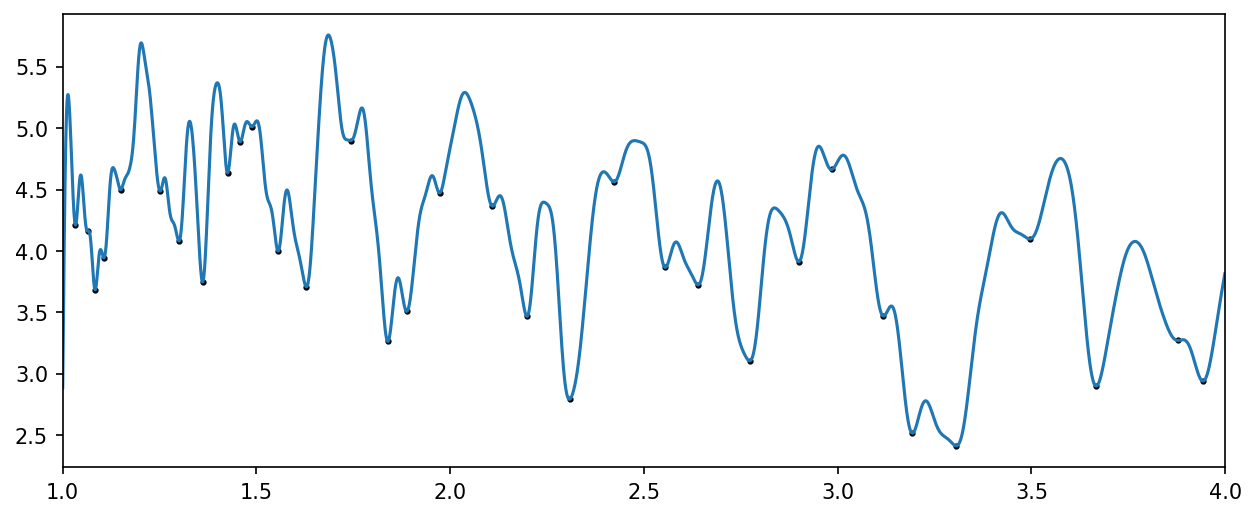

1.8409929275512695


In [28]:
import time
start = time.time()
data = epochs_data[7][20][0:6000] # Define data (single time series)
biotuning = biotuner(1000, peaks_function = 'harmonic_peaks', precision = 0.1, n_harm = 10,
                    ratios_n_harms = 10, ratios_inc_fit = False, ratios_inc = True) # Initialize biotuner object
biotuning.peaks_extraction(data, ratios_extension = True, max_freq = 50)
biotuning.compute_peaks_metrics()
biotuning.peaks_extension(method = 'harmonic_fit', harm_function = 'mult', cons_limit = 0.1, ratios_extension = True)
#biotuning.compute_diss_curve(plot = True, input_type = 'peaks', euler_comp = False, denom = 50, max_ratio = 2, n_tet_grid = 7)
#biotuning.compute_spectromorph(comp_chords = True, method = 'SpectralCentroid', min_notes = 5, cons_limit = 0.2, cons_chord_method = 'cons', 
                               #window = 500, overlap = 1, graph = True)

biotuning.compute_harmonic_entropy(input_type = 'extended_peaks', plot_entropy = True, octave = 4, rebound = False, sub=False)
stop = time.time()
print(stop-start)

In [21]:
biotuning.var

AttributeError: 'biotuner' object has no attribute 'var'

In [ ]:
biotuning.compute_harmonic_entropy(input_type = 'extended_peaks', spread = 0.01, plot_entropy = True, octave = 2, rebound = True)

In [ ]:
biotuning.compute_diss_curve(plot = False, input_type = 'peaks', denom = 50, max_ratio = 3, consonance = False, n_tet_grid = 12)

In [ ]:
#IF = np.moveaxis(biotuning.IF, 0 ,1)
plt.plot(biotuning.IF[4][10:-10])

In [ ]:
np.var(biotuning.IF[4][10:-10])

In [ ]:
a = biotuning.spectro_chords[0]
#b = biotuning.spectro_chords[1]
#a
biotuning.spectro_chords

In [ ]:
biotuning.spectro_chords

In [ ]:
a = harmonic_fit(biotuning.peaks_ratios, 10, 0.01)
a

In [ ]:
biotuning.extended_peaks_ratios_inc

In [ ]:
def ratios_harmonics (ratios, n_harms = 1):
    ratios_harms = []
    for h in range(n_harms):
        h += 1 
        ratios_harms.append([i*h for i in ratios])
    ratios_harms = [i for sublist in ratios_harms for i in sublist]
    return ratios_harms

def ratios_increments (ratios, n_inc = 1):
    ratios_harms = []
    for h in range(n_inc):
        h += 1 
        ratios_harms.append([i**h for i in ratios])
    ratios_harms = [i for sublist in ratios_harms for i in sublist]
    ratios_harms = list(set(ratios_harms))
    return ratios_harms

In [ ]:
def harmonic_entropy (ratios, res = 0.001, spread = 0.01, plot_entropy = True, plot_tenney = False, octave = 2):
    fracs, numerators, denominators = scale2frac(ratios)
    ratios = numerators / denominators
    #print(ratios)
    #ratios = np.interp(ratios, (ratios.min(), ratios.max()), (1, 10))
    bendetti_heights = numerators * denominators
    tenney_heights = log2(bendetti_heights)

    ind = np.argsort(tenney_heights)  # first, sort by Tenney height to make things more efficient
    bendetti_heights = bendetti_heights[ind]
    tenney_heights = tenney_heights[ind]
    numerators = numerators[ind]
    denominators = denominators[ind]
    #ratios = ratios[ind]
    if plot_tenney == True:
        fig = plt.figure(figsize=(10, 4), dpi=150)
        ax = fig.add_subplot(111)
        # ax.scatter(ratios, 2**tenney_heights, s=1)
        ax.scatter(ratios, tenney_heights, s=1, alpha=.2)
        # ax.scatter(ratios[:200], tenney_heights[:200], s=1, color='r')
        plt.show()
    
    # Next, we need to ensure a distance `d` between adjacent ratios
    M = len(bendetti_heights)
    #print(M)

    delta = 0.00001
    indices = ones(M, dtype=bool)

    for i in range(M - 2):
        ind = abs(ratios[i + 1:] - ratios[i]) > delta
        indices[i + 1:] = indices[i + 1:] * ind

    bendetti_heights = bendetti_heights[indices]
    tenney_heights = tenney_heights[indices]
    numerators = numerators[indices]
    denominators = denominators[indices]
    ratios = ratios[indices]
    M = len(tenney_heights)
    #print(M)
    #print('hello')
    x_ratios = arange(1, octave, res)
    _, HE = compute_harmonic_entropy_domain_integral(ratios, x_ratios, spread=spread)
    #_, HE = compute_harmonic_entropy_simple_weights(numerators, denominators, x_ratios, spread=0.01)
    ind = argrelextrema(HE, numpy.less)
    HE_minima = (x_ratios[ind], HE[ind])
    if plot_entropy == True:  
        fig = plt.figure(figsize=(10, 4), dpi=150)
        ax = fig.add_subplot(111)
        # ax.plot(weight_ratios, log2(pdf))
        ax.plot(x_ratios, HE)
        # ax.plot(x_ratios, HE_simple)
        ax.scatter(HE_minima[0], HE_minima[1], color='k', s=4)
        ax.set_xlim(1, octave)
        plt.show()
    return HE_minima, np.average(HE)

In [ ]:
def spectro_chord_progression (spectro_chords):
    for i in spectro_chords:
        i = [int(j*100) for j in i]
        print(euler(*i))

In [ ]:
plt.plot(biotuning.SpectralFlux[0][1000:2000])
plt.plot(biotuning.SpectralFlux[1][1000:2000])
plt.plot(biotuning.SpectralFlux[2][1000:2000])

In [ ]:
data = biotuning.SpectralCentroid
#data = np.moveaxis(data, 0, 1)
cons_peaks = timepoint_consonance(data)

In [ ]:
cons_peaks

In [ ]:
harms = [10,50]
data = epochs_data[47][28] # Define data (single time series)
for i in harms:
    biotuning = biotuner(1000, peaks_function = 'EEMD', precision = 0.1, n_harm = i)
    biotuning.peaks_extraction(data)
    biotuning.peaks_extension(method = 'consonant_harmonic_fit', harm_function = 'mult', cons_limit = 0.1)
    biotuning.compute_harmonic_entropy(input_type = 'extended_peaks', plot_entropy = True)

In [ ]:
biotuning.extended_peaks

In [ ]:
a, b, c = oct_subdiv(3/2,0.01367,2,10)
m = compare_oct_div(Octdiv = 53, Octdiv2 = 12, bounds = 0.003, octave = 2)
m

In [ ]:
#a, b = multi_oct_subdiv (biotuning.peaks, 200, 0.01)
a

In [ ]:
def multi_oct_subdiv (peaks, max_sub, octave_limit, octave = 2, n_scales = 10):
    import itertools
    from collections import Counter
    a, b, pairs, cons = consonance_peaks(peaks, 0.01)
    ratios, cons = consonant_ratios(peaks, 0.01)
    print(ratios)
    list_oct_div = []
    for i in range(len(ratios)):
        list_temp, no= oct_subdiv(ratios[i], octave_limit, octave, n_scales)
        print(list_temp)
        list_oct_div.append(list_temp)


    counts = Counter(list(itertools.chain(*list_oct_div)))
    oct_div_temp = []
    for k, v in counts.items():
        if v > 1:
            oct_div_temp.append(k)
    oct_div_temp = np.sort(oct_div_temp)
    oct_div_final = []
    for i in range(len(oct_div_temp)):
        if oct_div_temp[i] < max_sub:
            oct_div_final.append(oct_div_temp[i])
    return oct_div_final, ratios

In [ ]:
biotuning = biotuner(1000, peaks_function = 'adapt', precision = 0.1, n_harm = 30)
biotuning = biotuning.fit_all(data)
biotuning.peaks_ratios

In [22]:
vars(biotuning)
#biotuning.HE_scale

{'sf': 1000,
 'peaks_function': 'harmonic_peaks',
 'precision': 0.1,
 'compute_sub_ratios': False,
 'n_harm': 10,
 'harm_function': 'mult',
 'extension_method': 'consonant_harmonic_fit',
 'scale_metrics': {'HE': 5.171780142255511,
  'HE_n_steps': 16,
  'HE_harm_sim': 2.429969830514736},
 'ratios_n_harms': 10,
 'ratios_harms': False,
 'ratios_inc': True,
 'ratios_inc_fit': False,
 'data': array([ 1.10725885e-05,  9.76327645e-06,  6.97484032e-06, ...,
        -2.51230134e-06, -2.16648645e-06, -5.52161718e-07]),
 'freqs': array([0.000e+00, 1.000e-01, 2.000e-01, ..., 4.998e+02, 4.999e+02,
        5.000e+02]),
 'psd': array([-116.5159471 , -113.86914783, -112.44835835, ..., -282.14862463,
        -286.12180141, -296.67849456]),
 'peaks': array([ 3.2,  4.6,  5.6,  7.7,  8.8, 11.6, 13.1, 27.7, 33.3, 47. ]),
 'amps': array([-110.26878255, -115.37442633, -119.42438403, -114.43661621,
        -119.37842234, -119.8894937 , -122.43431268, -125.52123172,
        -126.93682886, -127.86483657]),
 'pe